<a href="https://colab.research.google.com/github/astrrr/Image-Processing-Lab/blob/main/Activity11_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
import glob
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers
import random


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


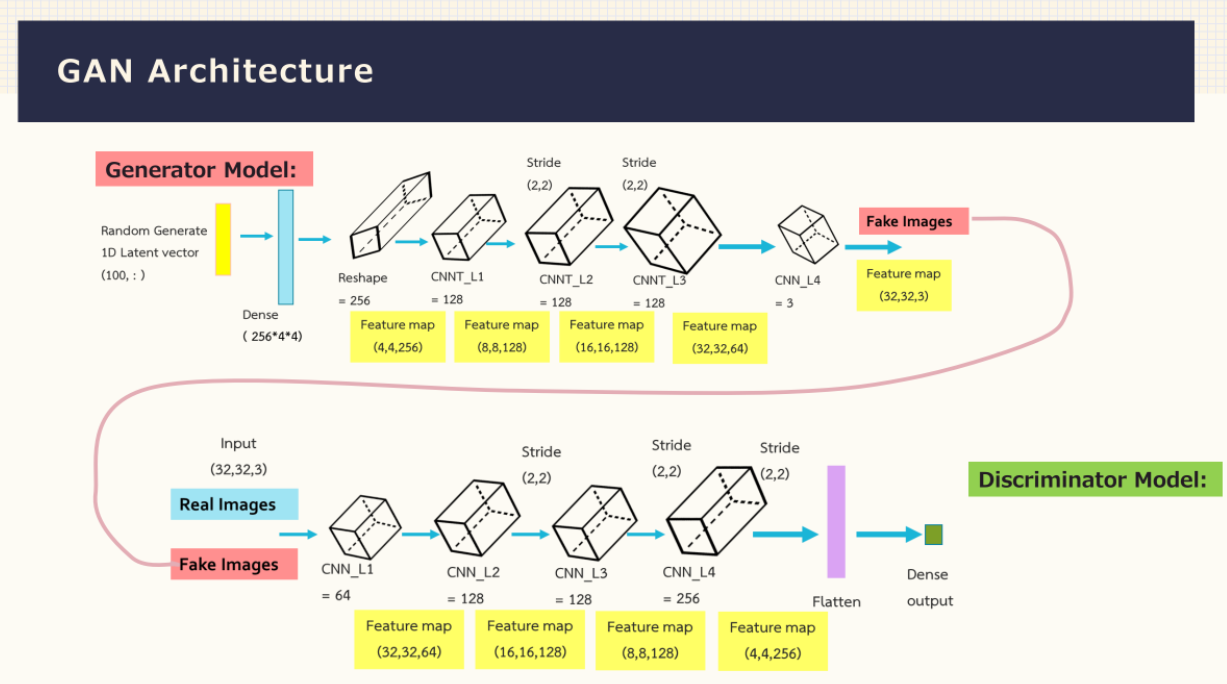

#11.1 PREPARE IMAGE DATA (REAL, FAKE )

* 11.1.1 Prepare Real Image

In [ ]:
#List all filename in art image path

img_size = (32, 32, 3)
filenames= glob.glob ('/content/drive/MyDrive/Art_Image_dataset/*/*/*')
# train_dataset # read image from dataset and resize to train_dataset.shape = img_size using interpolation="bilinear"
# rescale train_dataset values [0, 255] -> [-1, 1]

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_size[0], img_size[1], interpolation='bilinear'),
  layers.Rescaling(1./127.5, offset=-1)
])

In [ ]:
im_arr = []
for i in range(3000):
  img = image.load_img(filenames[i],target_size=img_size, interpolation='bilinear')
  
  #convert img to arr
  img = image.img_to_array(img)
  
  #normalizeed color img
  result = resize_and_rescale(img)

  im_arr.append(result)

In [ ]:
dataset = np.array(im_arr)

In [ ]:
dataset.shape

(3000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


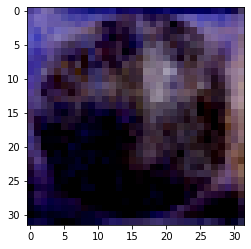

In [ ]:
plt.imshow(im_arr[8])

In [ ]:
# Random Selected images
def generate_real_samples(dataset, n_samples):
  y_temp = []
  ix = np.random.randint(0, dataset.shape[0], n_samples) # random image index
  
  # retrieve selected images
  x = dataset[ix] # get image from random pick ix
  
  # generate y = 1 for 'real' class labels
  # y #-> (y.shape = (n_samples,1))
  for i in range(n_samples):
    y = 1
    y_temp.append(y)
  
  x = np.array(x)
  y_temp = np.array(y_temp)
  return x, y_temp

In [ ]:
# Display Random Real Images
n_samples = 200
x_real, y_real = generate_real_samples(dataset, n_samples)
#imshow(X_real) # convert dtype to uint8

In [ ]:
print(y_real.shape)

(200,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

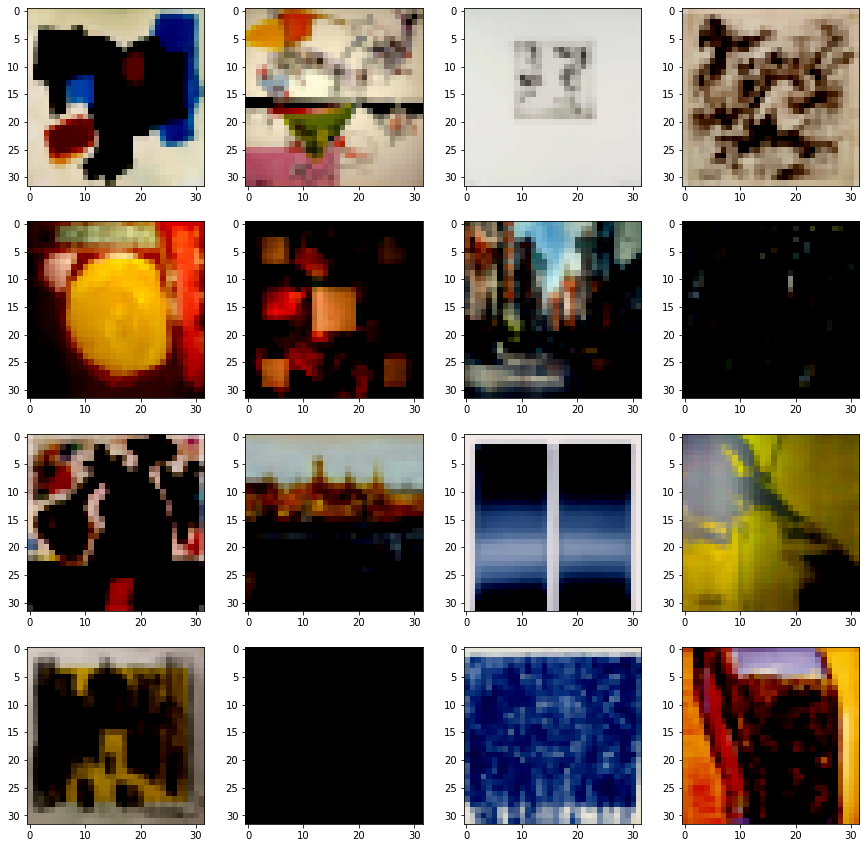

In [ ]:
fig = plt.figure(figsize=(15,15))
for i in range(16):
  ax = fig.add_subplot(4,4,i+1)
  plt.imshow(x_real[i])
plt.show()





* 11.1.2 Prepare Fake Image

In [ ]:
def generate_fake_samples(n_samples, target_size=(32,32,3)):
  x_temp = []
  y_temp = []
  h,w,c = target_size
  for i in range(n_samples):
    # generate 1D uniform random numbers in [0,1]
    # x = rand() #-> X.shape = (n_samples * h * w * 3)
    img = np.random.uniform(0.0, 1.0, (h,w,c))

    # rescale X value from [0, 1] to [-1, 1]
    # Xmax = 1, Xmin = -1
    result = np.array(img)
    result = resize_and_rescale(result)
    # reshape X from 1D to 4D
    # X.shape = (n_samples, h, w, c)
    x = result
    
    # generate y = 0 for 'fake' class label
    # y.shape = (n_samples,1)
    y = 0

    x_temp.append(x)
    y_temp.append(y)

  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp

In [ ]:
x_fake, y_fake = generate_fake_samples(n_samples, img_size)

In [ ]:
print(x_fake.shape)
print(y_fake.shape)

(200, 32, 32, 3)
(200,)


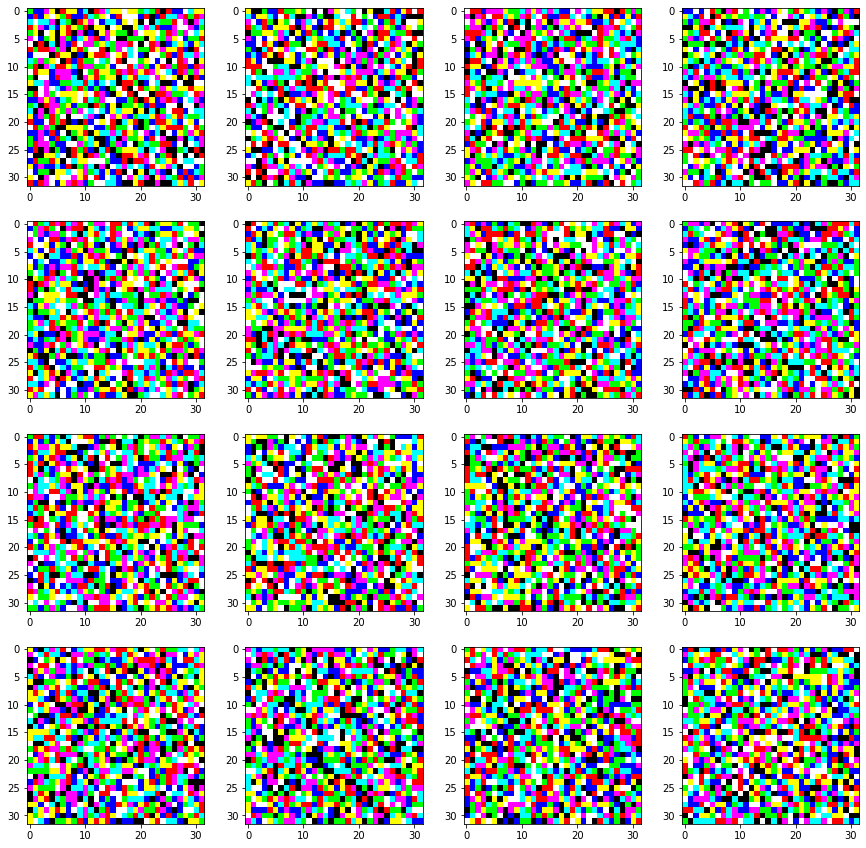

In [ ]:
# Display Random Real Images
#imshow(x_fake) 
# rescale to [0, 255] -> dtype = uint8



fake_temp = []
for i in range(200):
  
  x_temp = np.array(x_fake[i])

  temp = np.round((x_temp + 1) * 255 / 2)
  fake_temp.append(temp)

x_fake_scaled = np.array(fake_temp)


fig2 = plt.figure(figsize=(15,15))
for i in range(16):
  ax = fig2.add_subplot(4,4,i+1)
  plt.imshow(x_fake_scaled[i])
plt.show()



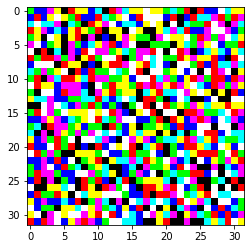

In [ ]:
plt.imshow(x_fake_scaled[0])

# 11.2 Prepare Discriminator, Generator Model

* 11.2.1 Create Discriminator Model (D) and Training

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Flatten, Dropout



In [ ]:

CNN_L1 = 64
CNN_L2 = 128
CNN_L3 = 128
CNN_L4 = 256

opt = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam') 
Train_loss = tf.keras.losses.binary_crossentropy 

# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(CNN_L1, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(CNN_L2, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(CNN_L3, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(CNN_L4, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss= Train_loss, optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    x_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(x_real, y_real)
    # generate 'fake' examples
    x_fake, y_fake = generate_fake_samples(half_batch, target_size=img_size)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(x_fake, y_fake)
    # summarize performance
    print('iter : ',i)
    print(f'real_acc: {real_acc} ,  fake_acc : {fake_acc}')
    print('=======================')

In [ ]:
# define model
d_model = define_discriminator(img_size)



In [ ]:
# summarize the model
d_model.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_151 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_244 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_152 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_245 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_153 (Conv2D)         (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_246 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_154 (Conv2D)         (None, 4, 4, 256)      

In [ ]:
# Training Discriminator
train_discriminator(d_model, dataset, target_size = img_size)

iter :  0
real_acc: 0.703125 ,  fake_acc : 0.0
iter :  1
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  2
real_acc: 0.890625 ,  fake_acc : 1.0
iter :  3
real_acc: 0.765625 ,  fake_acc : 1.0
iter :  4
real_acc: 0.859375 ,  fake_acc : 1.0
iter :  5
real_acc: 0.84375 ,  fake_acc : 1.0
iter :  6
real_acc: 0.921875 ,  fake_acc : 1.0
iter :  7
real_acc: 0.90625 ,  fake_acc : 1.0
iter :  8
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  9
real_acc: 0.9375 ,  fake_acc : 1.0
iter :  10
real_acc: 0.90625 ,  fake_acc : 1.0
iter :  11
real_acc: 0.984375 ,  fake_acc : 1.0
iter :  12
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  13
real_acc: 0.984375 ,  fake_acc : 1.0
iter :  14
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  15
real_acc: 1.0 ,  fake_acc : 1.0
iter :  16
real_acc: 0.984375 ,  fake_acc : 1.0
iter :  17
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  18
real_acc: 1.0 ,  fake_acc : 1.0
iter :  19
real_acc: 0.984375 ,  fake_acc : 1.0
iter :  20
real_acc: 0.953125 ,  fake_acc : 1.0
iter :  21
real_a

* 11.2.2 Create Generator Model (G)

In [ ]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, discr_out = (256,4,4)):
  model = Sequential()

  # foundation for 4x4 image
  c, w, h = discr_out
  n_nodes = c * w * h
  model.add(Dense(n_nodes, input_dim=(latent_dim)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((w, h, c)))
  
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # upsample to 16x16
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # upsample to 32x32
  model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [ ]:
# define the generator model

g_model = define_generator(latent_dim=100)

In [ ]:
# summarize the model
g_model.summary()

Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_248 (LeakyReLU)  (None, 4096)             0         
                                                                 
 reshape_31 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_93 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_249 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_transpose_94 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                         

# 11.3 GAN Training and Prediction

* 11.3.1 Create GAN Model (G,D) and Training

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    # connect them
    model = Sequential()

    # add generator
    model.add(g_model)

    # add the discriminator
    model.add(d_model)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# update generate fake image using generator prediction
# use the generator to generate n fake examples, with class labels

def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples))   # y = 0 with shape (n_sample, )
    return X, y

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print(acc_real , acc_fake)

    # save plot
    # plt.plot(x_real[:, 0], x_real[:, 1])
    # plt.plot(x_fake[:, 0], x_fake[:, 1])
    # # save plot to file
    # filename1 = '/content/drive/MyDrive/dataset_lab11/out/fig/generated_plot_%04d.png' % (epoch+1)
    # plt.savefig(filename1)
    # plt.close()
    #save_plot(x_fake, epoch)

    # save the generator model tile file
    filename = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [ ]:
EP = 1000

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=EP, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real) # update discriminator model weights

            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # update discriminator model weights

            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))  # create inverted labels for the fake samples y = 0 with shape (n_batch, )

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'd_loss1 : {d_loss1}, d_loss2 : {d_loss2}, g_loss: {g_loss}') # summarize loss on this batch
            print('')
            print('============================================================================================')
            # evaluate the model performance, every Nepoch
            if (i+1) % n_epochs == 0:
              summarize_performance(i, g_model, d_model, dataset, latent_dim)

* 11.3.2 Create GAN Model (G,D) and Training

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_146 (Sequential)  (None, 32, 32, 3)        1466115   
                                                                 
 sequential_145 (Sequential)  (None, 1)                522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, 100)

Streaming output truncated to the last 5000 lines.
d_loss1 : 0.32390546798706055, d_loss2 : 0.12054406851530075, g_loss: 2.83461594581604

d_loss1 : 0.2811487913131714, d_loss2 : 0.38608866930007935, g_loss: 2.7453994750976562

d_loss1 : 0.11791031807661057, d_loss2 : 0.4095759987831116, g_loss: 3.081714391708374

d_loss1 : 0.14035475254058838, d_loss2 : 0.18864601850509644, g_loss: 3.9785115718841553

d_loss1 : 0.4167654514312744, d_loss2 : 0.17508922517299652, g_loss: 3.7919392585754395

d_loss1 : 0.12195487320423126, d_loss2 : 0.054346032440662384, g_loss: 3.9023032188415527

d_loss1 : 0.2303471565246582, d_loss2 : 0.23812292516231537, g_loss: 3.3607466220855713

d_loss1 : 0.21657510101795197, d_loss2 : 0.3158935606479645, g_loss: 3.7027993202209473

d_loss1 : 0.1732066571712494, d_loss2 : 0.14081743359565735, g_loss: 3.7245936393737793

d_loss1 : 0.25468066334724426, d_loss2 : 0.1256410777568817, g_loss: 3.6691417694091797

d_loss1 : 0.2081276923418045, d_loss2 : 0.1705252081155777

# Prediction

In [ ]:
from tensorflow.keras.models import load_model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

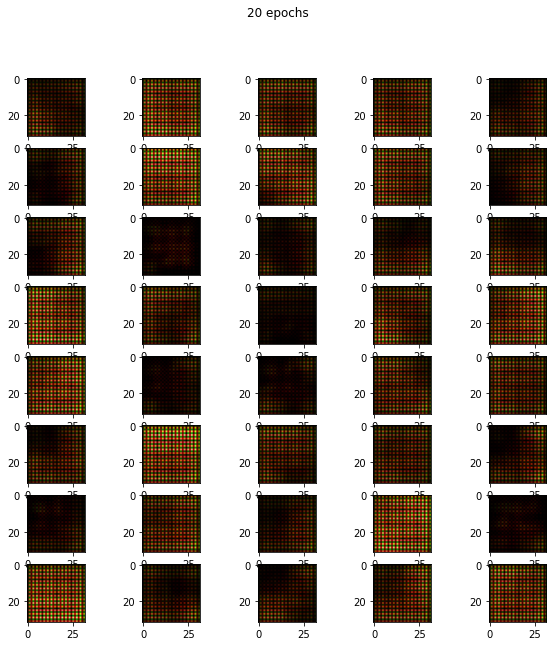

In [ ]:
# 20 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("20 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_020.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

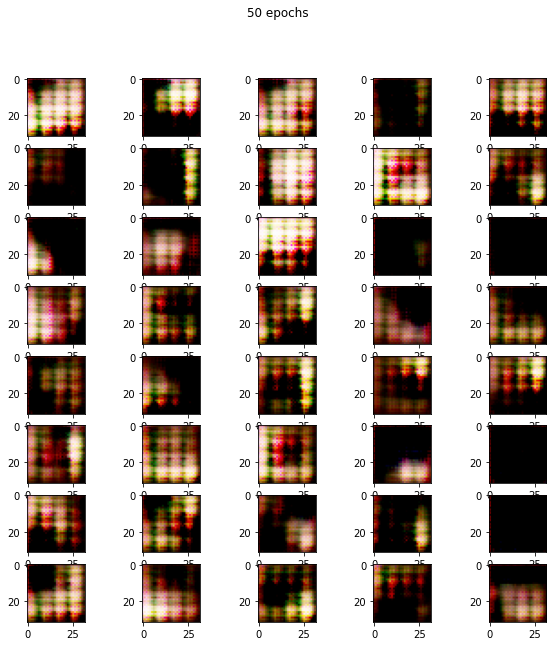

In [ ]:
# 50 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("50 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_050.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

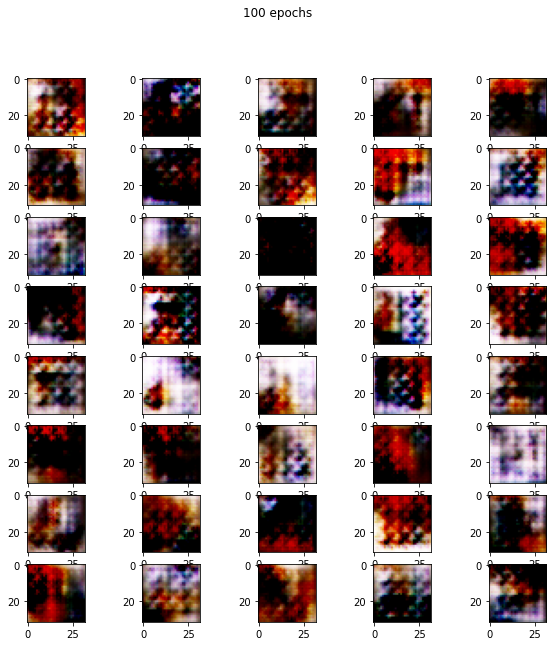

In [ ]:
# 100 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("100 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_100.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

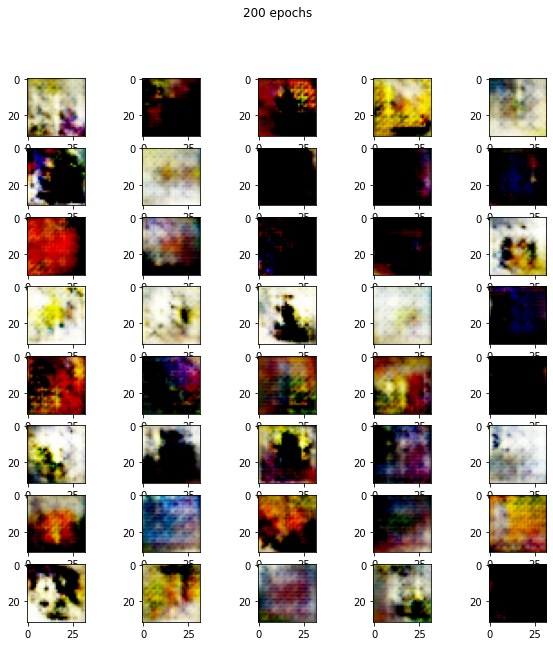

In [ ]:
# 200 epochs
fig = plt.figure(figsize=(10, 10))
fig.suptitle("200 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_200.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

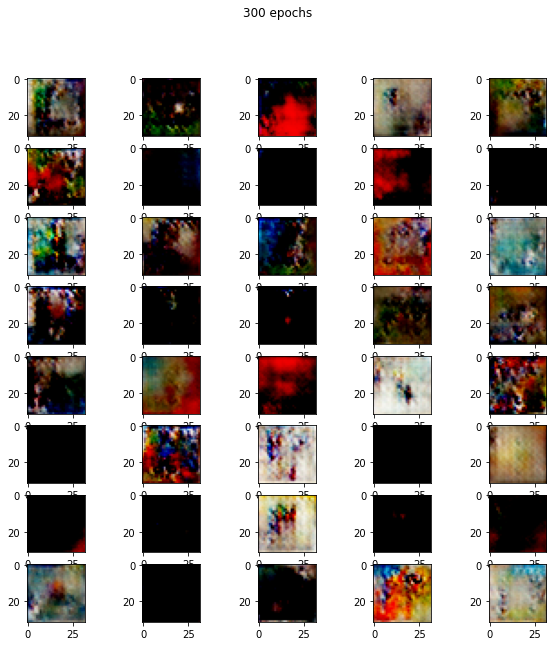

In [ ]:
# 300 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("300 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_300.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

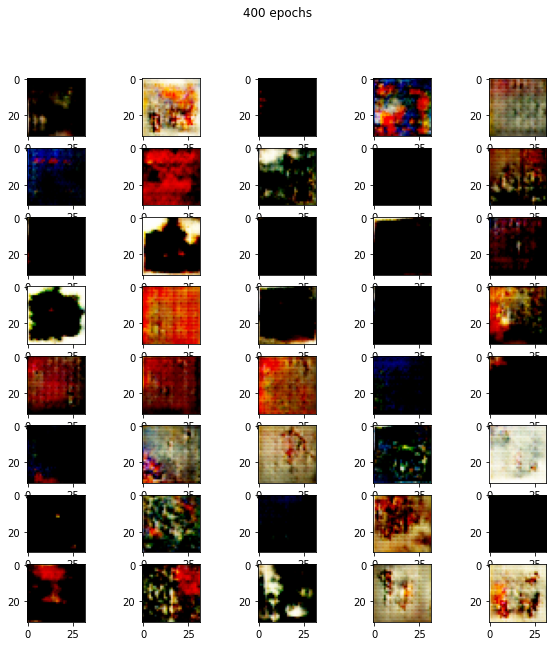

In [ ]:
# 400 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("400 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_400.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

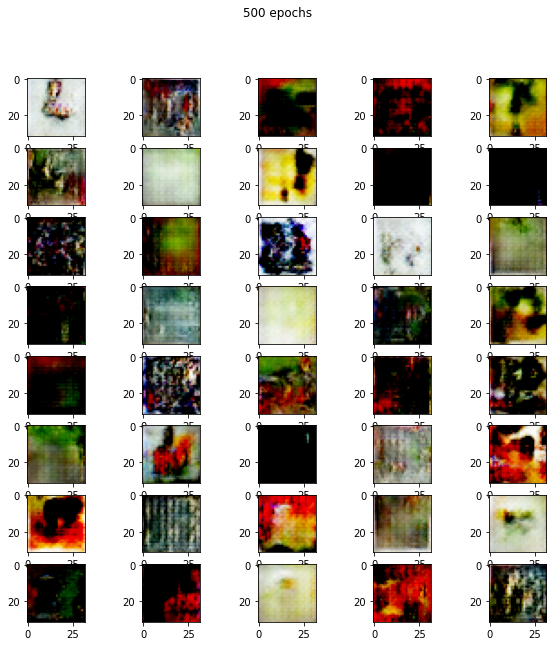

In [ ]:
# 500 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("500 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_500.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

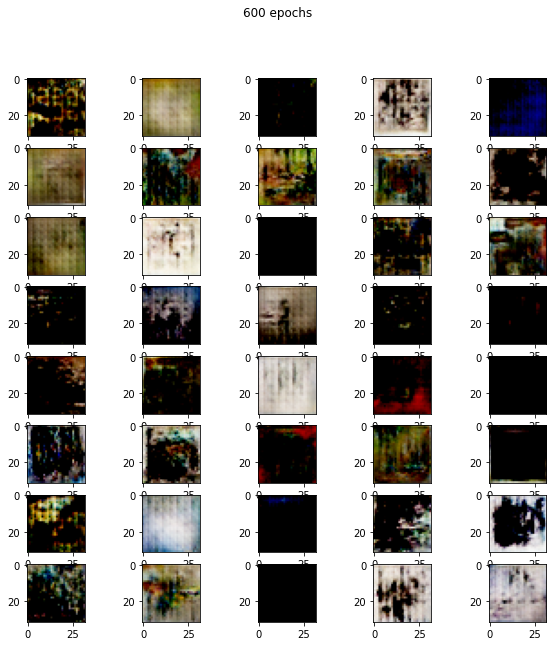

In [ ]:
# 600 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("600 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_600.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

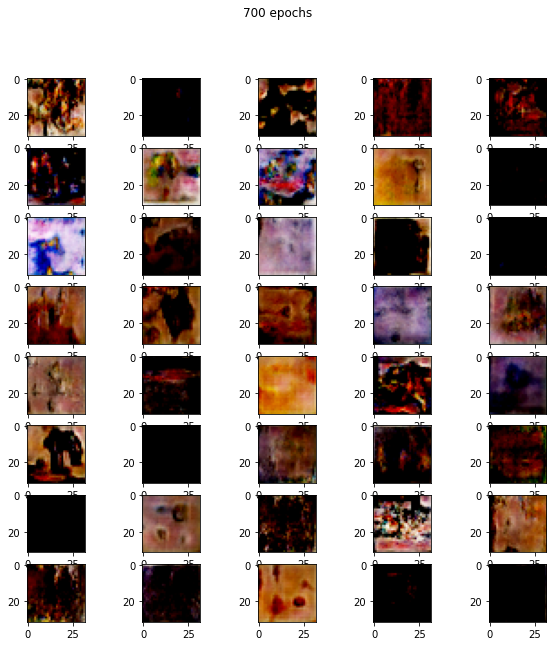

In [ ]:
# 700 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("700 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_700.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

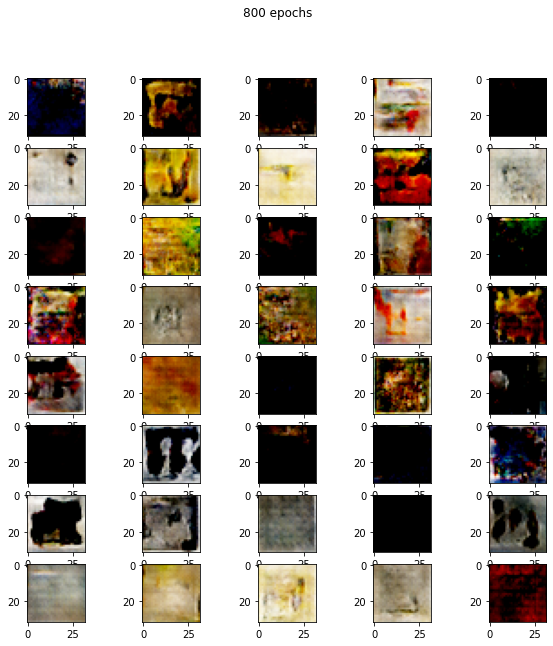

In [ ]:
# 800 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("800 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_800.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

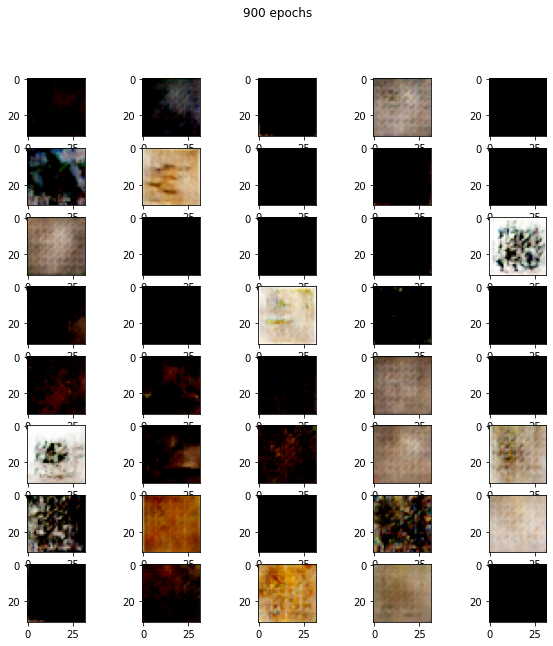

In [ ]:
# 900 epochs

fig = plt.figure(figsize=(10, 10))
fig.suptitle("900 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_900.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

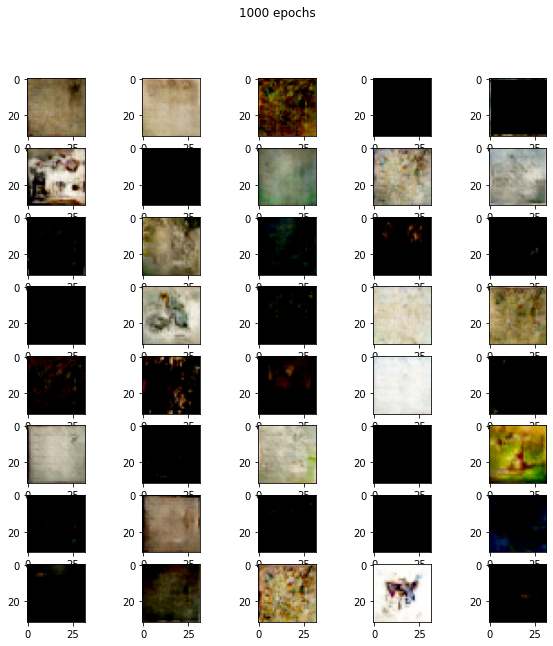

In [ ]:
# 1000 epochs
fig = plt.figure(figsize=(10, 10))
fig.suptitle("1000 epochs")

model_name = '/content/drive/MyDrive/dataset_lab11/out/model/generator_model_1000.h5'
model = load_model(model_name)

x, _ = generate_fake_samples(model, 100, 200)

for i in range(40):
  fig.add_subplot(8, 5, i+1)
  plt.imshow(x[i])
plt.show()